# Checking out some instances to check if everything works fine

In [12]:
# import the stuff
from cetsp_bnb2 import Circle, Instance, compute_tour_by_2opt, branch_and_bound, Point, plot_solution, compute_tour_from_sequence, TripleMap

In [13]:
# Load instances
import aemeasure
db_ = aemeasure.Database("instance_db")
data = db_.load()
instances = {instance["instance"]: instance  for instance in data}

In [14]:
list(instances.keys())

['srpg_octa0000092/upper_bound_70.json',
 'srpg_octa0000092/upper_bound_27.json',
 'srpg_octa0000092/upper_bound_31.json',
 'srpg_octa0000092/upper_bound_66.json',
 'srpg_octa0000092/upper_bound_5.json',
 'srpg_octa0000092/upper_bound_9.json',
 'srpg_octa0000092/upper_bound_11.json',
 'srpg_octa0000092/upper_bound_46.json',
 'srpg_octa0000092/upper_bound_50.json',
 'srpg_octa0000092/lower_bound_2.json',
 'srpg_octa0000092/upper_bound_51.json',
 'srpg_octa0000092/upper_bound_47.json',
 'srpg_octa0000092/upper_bound_8.json',
 'srpg_octa0000092/upper_bound_10.json',
 'srpg_octa0000092/upper_bound_4.json',
 'srpg_octa0000092/upper_bound_67.json',
 'srpg_octa0000092/upper_bound_30.json',
 'srpg_octa0000092/upper_bound_26.json',
 'srpg_octa0000092/upper_bound_71.json',
 'srpg_octa0000092/upper_bound_17.json',
 'srpg_octa0000092/upper_bound_40.json',
 'srpg_octa0000092/upper_bound_56.json',
 'srpg_octa0000092/upper_bound_21.json',
 'srpg_octa0000092/upper_bound_37.json',
 'srpg_octa0000092/up

In [15]:
instance = Instance([Circle(Point(float(d["x"]), float(d["y"])), float(d["radius"])) for d in instances['srpg_octa0000092/lower_bound_2.json']["circles"]])

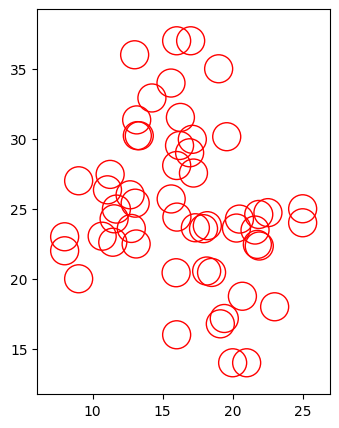

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plot_solution(plt.gca(), instance, [])

In [17]:
# compute an initial solution via 2opt
initial_solution = compute_tour_by_2opt(instance)

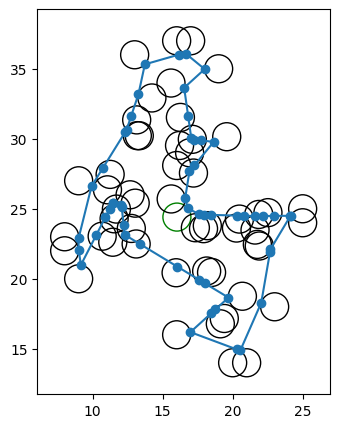

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plot_solution(plt.gca(), instance, initial_solution, highlight=[15])

In [19]:
import typing
import networkx as nx
import itertools

import gurobipy as gp  # requires gurobi to be installed via conda.
from gurobipy import GRB

class TripleVars:
    def __init__(self, graph: nx.Graph, model: gp.Model):
        self.graph = graph
        self._vars = model.addVars(self.all_triples(), lb=0, ub=1.0, vtype=GRB.BINARY)
        self.model = model

    def all_triples(self):
        for v in self.graph.nodes:
            for n0, n1 in itertools.combinations(self.graph.neighbors(v),2):
                yield min(n0, n1), v, max(n0, n1)

    def get(self, n0, v, n1):
        n0, n1 = min(n0, n1), max(n0, n1)
        return self._vars[(n0, v, n1)]

    def var_sum(self, source, target=None):
        if target is None:
            return sum(self.get(n0, source, n1) for n0, n1  in itertools.combinations(self.graph.neighbors(source),2))
        return sum(self.get(n, source, target) for n in self.graph.neighbors(source) if n!=target)
    
    def get_solution(self, lazy=False):
        graph =  nx.Graph()
        for t,x in self._vars.items():
            val = self.model.cbGetSolution(x) if lazy else x.X
            if val > 0.01:
                graph.add_edge(t[0],  t[1])
                graph.add_edge(t[1], t[2])
        return graph


class LowerBoundLp:
    def __init__(self, triple_map: TripleMap, sequence: typing.List[int], sample: typing.List[int]):
        self.model = gp.Model()
        self.graph = self._create_graph(sequence, sample)
        self.vars = TripleVars(self.graph, self.model)
        self.triple_map = triple_map
        self._enforce_coverage()
        self._enforce_flow()
        self._minimize_costs()
    
    def _minimize_costs(self):
        obj = sum(self.triple_map.get_cost(n0,v,n1)*self.vars.get(n0,v,n1) for n0,v,n1 in self.vars.all_triples())
        self.model.setObjective(obj, GRB.MINIMIZE)
    
    def _enforce_coverage(self):
        for v in self.graph:
            self.model.addConstr(self.vars.var_sum(v)==1)
    
    def _enforce_flow(self):
        for v,w in self.graph.edges:
            self.model.addConstr(self.vars.var_sum(v,w)==self.vars.var_sum(w,v))
            

    def _create_graph(self, sequence, sample):
        graph = nx.Graph()
        # the current tour
        for i, v in enumerate(sequence):
            graph.add_edge(v, sequence[(i+1)%len(sequence)])

        # connect sample to all other
        for v in sample:
            nodes = list(graph.nodes)
            for n in nodes:
                graph.add_edge(v,n)

        return graph
    
    def prohibit_subtour(self, subset, lazy=False):
        constr =  0
        for v in subset:
            for n in self.graph.neighbors(v):
                if n in subset:
                    continue
                constr += self.vars.var_sum(v, n)
        if lazy:
            self.model.cbLazy(constr>=2)
        else:
            self.model.addConstr(constr>=2)
                
        
    
    def optimize(self):
        def cb(model, where):
            if where==GRB.Callback.MIPSOL:
                g = self.vars.get_solution(lazy=True)
                cc = list(nx.connected_components(g))
                if len(cc)==1:
                    return
                else:
                    for c in cc:
                        self.prohibit_subtour(c, lazy=True)
        self.model.setParam("OutputFlag", False)
        self.model.Params.LazyConstraints = 1
        connected = False
        while not connected:
            self.model.optimize()
            g = self.vars.get_solution(lazy=False)
            cc = list(nx.connected_components(g))
            if len(cc)==1:
                connected = True
                break
            else:
                #print(cc)
                for c in cc:
                    self.prohibit_subtour(c, lazy=False)
        return self.model.objVal

Using ChFarthestCircle-Branching
Using DfsBfs search
Starting with root node of size 14
i	LB	|	UB
LB 55.059343531882874 51.91417283294237 55.059343531882874 55.059343531882874


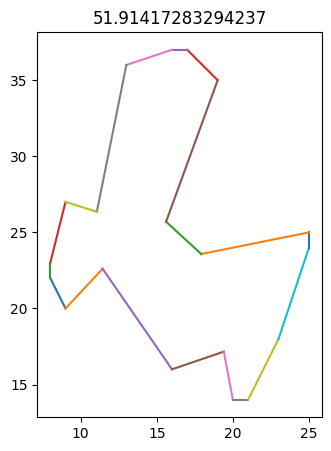

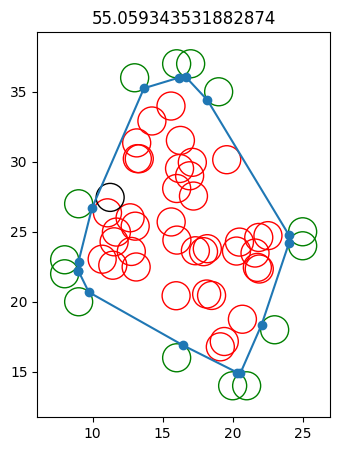

0	60.2736	|	74.4431
LB 60.2735712503797 52.49557725488732 60.2735712503797 60.2735712503797
1	60.3318	|	74.4431
LB 60.33178453321579 54.39026148530985 62.99252323130819 62.99252323130819
2	60.3318	|	74.4431
LB 60.33178453321579 54.64020487308497 64.22436342595196 64.22436342595196
3	60.3318	|	74.4431
4	60.3318	|	74.4431
5	60.3318	|	74.4431
6	60.3318	|	74.4431
7	60.3318	|	74.4431
8	60.3318	|	74.4431
9	60.3318	|	74.4431
10	60.3318	|	74.4431
20	60.3318	|	74.4431
LB 60.33178453321579 53.87364447585849 60.33178453321579 60.33178453321579
LB 61.21004270594053 54.8145623669503 63.11474320379539 63.11474320379539
LB 61.21004270594053 55.76224955834496 65.36246440089853 65.36246440089853
30	61.21	|	71.0406
40	61.21	|	71.0406
LB 61.21004270594053 55.49093578966376 61.21004270594053 61.21004270594053
LB 62.47450789397534 51.491736113825155 64.0403475868128 64.0403475868128
LB 62.47450789397534 56.58698324073118 65.93455810903863 65.93455810903863
50	62.4745	|	69.7232
LB 62.47450789397534 56.84824

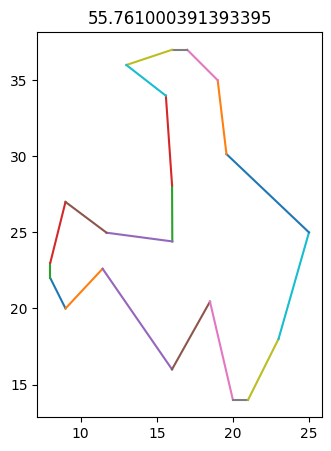

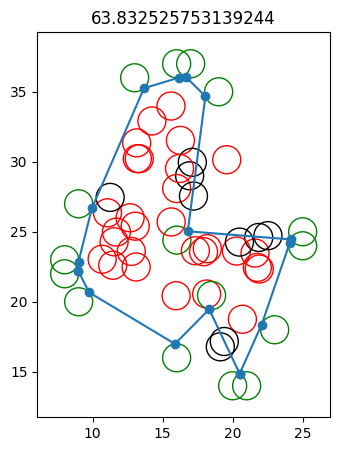

100	64.3364	|	69.4943
LB 64.33637967319501 57.90159899030039 66.08025663793548 66.08025663793548
LB 64.33637967319501 58.60212522653721 64.33637967319501 64.33637967319501
LB 64.38845667373253 59.68687639009515 66.58416303583489 66.58416303583489
LB 64.38845667373253 55.1563088570275 64.38845667373253 64.38845667373253
LB 64.63945286440162 56.98576043785503 66.07197049017064 66.07197049017064
LB 64.63945286440162 54.47786646336456 64.63945286440162 64.63945286440162
LB 64.71077927285151 54.89969619481686 64.71077927285151 64.71077927285151
LB 64.75022552545951 57.927675769302255 66.39469488635278 66.39469488635278
LB 64.75022552545951 56.48408801227373 64.75022552545951 64.75022552545951
LB 65.06220455336471 55.65185850298505 65.06220455336471 65.06220455336471
LB 65.21747245396523 59.98936185865879 67.89251532134759 67.89251532134759
LB 65.21747245396523 54.516605709536925 65.21747245396523 65.21747245396523
LB 65.22852127372133 56.33973090309333 67.08543890188352 67.08543890188352
LB

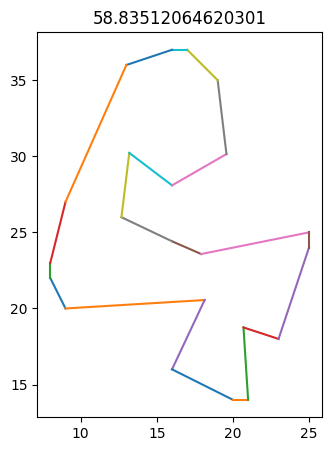

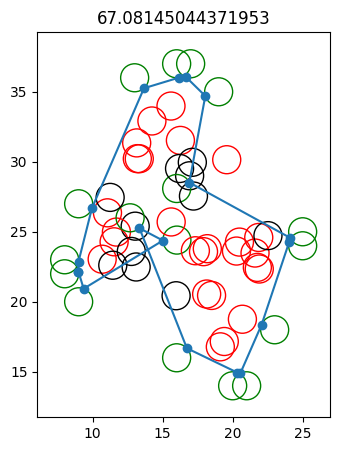

300	67.1498	|	68.8485
LB 67.21277608288521 58.12554298104709 67.21277608288521 67.21277608288521
LB 67.23906205484424 55.906328842016265 67.23906205484424 67.23906205484424
LB 67.2441916103107 58.2992019749654 67.2441916103107 67.2441916103107
LB 67.27041040314023 58.39133312132249 67.27041040314023 67.27041040314023
LB 67.2863305066275 58.585642740227875 67.2863305066275 67.2863305066275
LB 67.3855736517893 52.48028663542341 67.3855736517893 67.3855736517893
LB 67.4662138225029 54.63518262326014 67.4662138225029 67.4662138225029
LB 67.53813368026204 56.55374157464097 67.53813368026204 67.53813368026204
LB 67.5854751197095 58.398567447443135 67.5854751197095 67.5854751197095
LB 67.6234814539343 58.101568924252824 67.6234814539343 67.6234814539343
LB 67.65932310700808 53.054755418803566 67.65932310700808 67.65932310700808
LB 67.66002266534373 52.79585887920353 67.66002266534373 67.66002266534373
400	67.6625	|	68.8485
LB 67.6639154124684 56.86743025608911 67.6639154124684 67.663915412468

In [20]:
#     plt.figure(figsize=(5, 5))
#    for i,j in lp.graph.edges:
#        plt.plot([instance[i].center.x,instance[j].center.x],[instance[i].center.y,instance[j].center.y], "-")
#    plt.show()

timelimit = 220
node_values = []
tm = TripleMap(instance)
import random
def count(event):
    if event.current_node.depth()>3:
        return
    global tm

    ub = event.get_upper_bound()
    lb = event.get_lower_bound()
    
    missing_circles = [i for i,circle in enumerate(instance.circles()) if event.current_node.get_relaxed_solution().distance(circle) >= 0.1]
    missing_circles = list(random.sample(missing_circles, min(5, len(missing_circles))))
    
    lp = LowerBoundLp(tm, event.current_node.get_spanning_sequence(), missing_circles)

    lp_lb = lp.optimize()

    print("LB", lb, lp_lb, event.get_relaxed_solution().length(), event.current_node.get_lower_bound())
    event.current_node.add_lower_bound(lp_lb)

    if event.num_iterations % 100 == 0:
        plt.figure(figsize=(5, 5))
        plt.gca().set_aspect("equal", "box")
        plt.title(lp_lb)
        for i,j in lp.vars.get_solution().edges:
                plt.plot([instance[i].center.x,instance[j].center.x],[instance[i].center.y,instance[j].center.y], "-")
        plt.show()
        plt.figure(figsize=(5, 5))
        plot_solution(plt.gca(), instance, event.get_relaxed_solution(), highlight=event.current_node.get_fixed_sequence())
        plt.title(event.get_relaxed_solution().length())
        plt.show()
        plt.close()
        
opt_solution, lb = branch_and_bound(instance, count, initial_solution, timelimit)

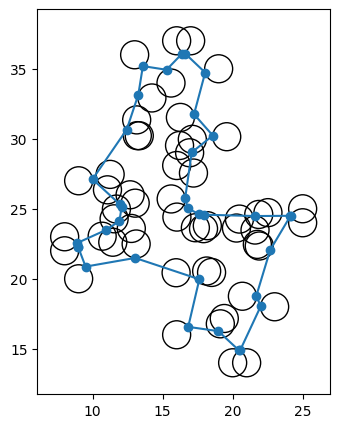

In [21]:
plt.figure(figsize=(5, 5))
plot_solution(plt.gca(), instance, opt_solution)